In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from core import bw_color_palette
import numpy as np
from sklearn import metrics
from dna_features_viewer import GraphicFeature, GraphicRecord
import matplotlib.text as mtext
from matplotlib.colors import TwoSlopeNorm
import textwrap
import gpplot

In [3]:
plt.rcParams['font.size'] = 7
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6

In [4]:
hhblits_df = pd.read_csv('../data3/interim/ecor_unique_plus_cloned_df_domains.csv')
pred_df = pd.read_csv('../data3/interim/ecor_predictions_defensive_cat.csv')
all_library_info = pd.read_csv('../data3/interim/all_library_info.csv')
v1_neg_info = pd.read_csv('../data/raw/Beaker rebuttal domains - hit_proteins.csv')

/state/partition1/slurm_tmp/1819257.0.0/ipykernel_2555952/2304820045.py:2: DtypeWarning: Columns (24,30,35) have mixed types. Specify dtype option on import or set low_memory=False.
  pred_df = pd.read_csv('../data3/interim/ecor_predictions_defensive_cat.csv')


In [5]:
hhblits_df['query'].nunique()

11302

In [6]:
top_hhblits_df = (hhblits_df.sort_values('Prob', ascending=False)
                  .groupby('query')
                  .head(1))

In [7]:
select_negatives = pd.read_csv('../data3/external/HHPred negatives - hit_proteins.csv')

In [9]:
merged_select_negatives = (select_negatives.drop(columns=['log_odds'])
                           .merge(pred_df[['product_accession', 'genomic_accession', 'start', 'mean_log_odds']], how='inner', 
                                                  on=['product_accession', 'genomic_accession', 'start'])
                           .merge(top_hhblits_df[['query', 'hit_name', 'Prob']], left_on='product_accession', right_on='query', how='left'))

In [12]:
p = top_hhblits_df['Prob']
print(p[p != 0].min())
print(p[p != 100].max())

0.1
99.9


In [13]:
def remap_prob(p, epsilon=0.1):
    if p == 0:
        return epsilon
    elif p == 100:
        return 100 - epsilon
    else:
        return p

In [14]:
pred_df['hit_category'].unique()

array(['Not defensive', 'Defense homolog in new context',
       'Predicted novel defense gene',
       'Defense homolog in expected system', 'Remote defense homolog'],
      dtype=object)

In [15]:
operon_max_log_odds = (pred_df.groupby('operon')
                       .agg(operon_max_log_odds=('mean_log_odds', 'max'))
                       .reset_index())

In [16]:
merged_preds = (pred_df
                .sort_values('mean_log_odds', ascending=False)
                .groupby('product_accession')
                .head(1)
                .merge(top_hhblits_df[['query', 'Prob', 'qstart', 'qend', 'hit_name']]
                       .rename(columns={'query': 'product_accession',
                                        'Prob': 'defense_nn_prob',
                                        'qstart': 'defense_nn_qstart',
                                        'qend': 'defense_nn_qend',
                                        'hit_name': 'defense_nn_name'}), 
                       how='inner', on='product_accession')
                .merge(operon_max_log_odds, how='inner', on='operon'))
merged_preds['defense_nn_prob'] = merged_preds['defense_nn_prob'].apply(remap_prob)
merged_preds['defense_nn_lo'] = np.log((merged_preds['defense_nn_prob']/100)/(1 - (merged_preds['defense_nn_prob']/100)))
merged_preds['hit_category'] = pd.Categorical(merged_preds['hit_category'], 
                                              categories=['Defense homolog in expected system', 
                                                          'Defense homolog in new context', 
                                                          'Remote defense homolog', 
                                                          'Predicted novel defense gene', 
                                                          'Not defensive'])

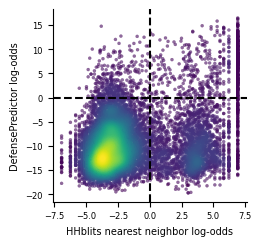

In [23]:
plt.subplots(figsize=(2.5,2.5))
gpplot.point_densityplot(data=merged_preds, x='defense_nn_lo', y='mean_log_odds', 
                         s=5)
plt.xlabel('HHblits nearest neighbor log-odds')
plt.ylabel('DefensePredictor log-odds')
plt.axvline(x=0, linestyle='dashed', color='black')
plt.axhline(y=0, linestyle='dashed', color='black')
sns.despine()
plt.savefig('../figures/defensepredictor_v_hhblits.svg', dpi=300, bbox_inches='tight')

In [30]:
merged_preds.query("hit_category == 'Defense homolog in expected system'")

protein_context_id  mean_log_odds  sd_log_odds   
1      WP_087888065.1|NZ_QOXG01000055.1|10684|-      15.053837     0.855995  \
2       WP_087888067.1|NZ_QOXG01000055.1|2551|-       9.812046     0.879969   
3       WP_071337576.1|NZ_QOXQ01000045.1|8670|-      16.351587     2.979544   
7     WP_042341885.1|NZ_QOYY01000002.1|103238|-      12.731995     0.227967   
9     WP_042341895.1|NZ_QOYY01000002.1|111063|-       4.422353     2.834051   
...                                         ...            ...          ...   
1593   WP_114412981.1|NZ_QOYT01000054.1|53932|+      -1.550680     1.503109   
1900    WP_250112119.1|NZ_QOWQ01000067.1|2953|+      -2.531136     0.774754   
1912     WP_048216953.1|NZ_RRWS01000010.1|342|-      -2.580980     2.329967   
3192   WP_250112115.1|NZ_QOWQ01000061.1|10498|+      -5.762029     1.098489   
4220   WP_162754931.1|NZ_RRWI01000019.1|62632|+      -7.511847     2.260627   

      min_log_odds  max_log_odds # feature         class         assembly   
1        14.137463     16.434248       CDS  with_protein  GCF_003334145.1  \
2         8.228167     10.786774       CDS  with_protein  GCF_003334145.1   
3        11.354729     20.303696       CDS  with_protein  GCF_003333945.1   
7        12.330185     12.960514       CDS  with_protein  GCF_003333435.1   
9        -1.225025      6.261232       CDS  with_protein  GCF_003333435.1   
...            ...           ...       ...           ...              ...   
1593     -3.898808      0.458827       CDS  with_protein  GCF_003333565.1   
1900     -3.793838     -1.453998       CDS  with_protein  GCF_003334335.1   
1912     -5.931180      1.352963       CDS  with_protein  GCF_003892555.1   
3192     -7.220063     -4.112806       CDS  with_protein  GCF_003334335.1   
4220    -10.801562     -5.036823       CDS  with_protein  GCF_003892435.1   

         assembly_unit           seq_type  ...  hit_name q_cov  Prob   
1     Primary Assembly  unplaced scaffold  ...       NaN   0.0   NaN  \
2     Primary Assembly  unplaced scaffold  ...       NaN   0.0   NaN   
3     Primary Assembly  unplaced scaffold  ...       NaN   0.0   NaN   
7     Primary Assembly  unplaced scaffold  ...       NaN   0.0   NaN   
9     Primary Assembly  unplaced scaffold  ...       NaN   0.0   NaN   
...                ...                ...  ...       ...   ...   ...   
1593  Primary Assembly  unplaced scaffold  ...       NaN   0.0   NaN   
1900  Primary Assembly  unplaced scaffold  ...       NaN   0.0   NaN   
1912  Primary Assembly  unplaced scaffold  ...       NaN   0.0   NaN   
3192  Primary Assembly  unplaced scaffold  ...       NaN   0.0   NaN   
4220  Primary Assembly  unplaced scaffold  ...       NaN   0.0   NaN   

                            hit_category defense_nn_prob defense_nn_qstart   
1     Defense homolog in expected system            99.9              29.0  \
2     Defense homolog in expected system            99.9              70.0   
3     Defense homolog in expected system            99.9            1044.0   
7     Defense homolog in expected system            99.9             104.0   
9     Defense homolog in expected system            99.9               6.0   
...                                  ...             ...               ...   
1593  Defense homolog in expected system            99.9               3.0   
1900  Defense homolog in expected system            99.9               1.0   
1912  Defense homolog in expected system            99.9               7.0   
3192  Defense homolog in expected system            99.9              21.0   
4220  Defense homolog in expected system            99.9               3.0   

     defense_nn_qend                                    defense_nn_name   
1              717.0  UniRef50_A0A1F4DIW7 Gao_RL~RL_A AAA family ATP...  \
2              760.0  UniRef50_O86683 BREX~pglZ2 Alkaline phosphatas...   
3             1505.0  UniRef50_A0A150FQH3 RM_Type_II~Type_II_MTases ...   
7              692.0  UniRef50_P08956 RM~Type_I_REase

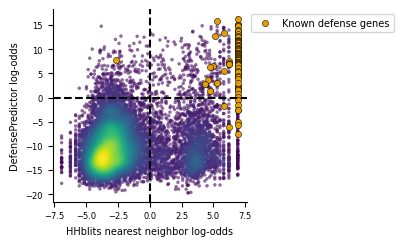

In [34]:
plt.subplots(figsize=(2.5,2.5))
sns.scatterplot(data=merged_preds.query("hit_category == 'Defense homolog in expected system'"), 
                x='defense_nn_lo', y='mean_log_odds', color=bw_color_palette[0], 
                edgecolor='black', s=20, label='Known defense genes', zorder=1)
gpplot.point_densityplot(data=merged_preds, x='defense_nn_lo', y='mean_log_odds', 
                         s=5, zorder=0)
plt.xlabel('HHblits nearest neighbor log-odds')
plt.ylabel('DefensePredictor log-odds')
plt.axvline(x=0, linestyle='dashed', color='black')
plt.axhline(y=0, linestyle='dashed', color='black')
sns.despine()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig('../figures/defensepredictor_v_hhblits_known.svg', dpi=300, bbox_inches='tight')

In [42]:
long_library_info = all_library_info[['working_id', 'genomic_accession', 'product_accessions', 'defensive']].copy()
long_library_info['product_accession'] = long_library_info['product_accessions'].str.split(', ')
long_library_info = long_library_info.explode('product_accession')

In [44]:
v1_neg_info['defensive'] = False
cat_library_info = pd.concat([long_library_info, 
                              v1_neg_info])

In [45]:
screened_df = (merged_preds.merge(cat_library_info, how='inner', on='product_accession')
               .sample(frac=1, random_state=7)
               .reset_index(drop=True))

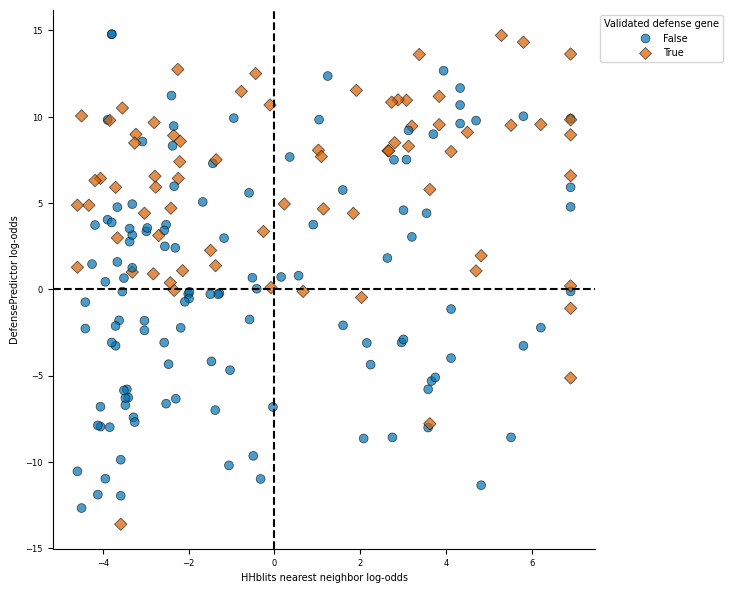

In [46]:
plt.subplots(figsize=(7,7))
sns.scatterplot(data=screened_df, x='defense_nn_lo', y='mean_log_odds', hue='defensive',
                palette=bw_color_palette[4:6], style='defensive', markers=["o", "D"],
                edgecolor='Black', alpha=0.7, s=40)
plt.xlabel('HHblits nearest neighbor log-odds')
plt.ylabel('DefensePredictor log-odds')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Validated defense gene')
plt.axvline(x=0, linestyle='dashed', color='black')
plt.axhline(y=0, linestyle='dashed', color='black')
sns.despine()

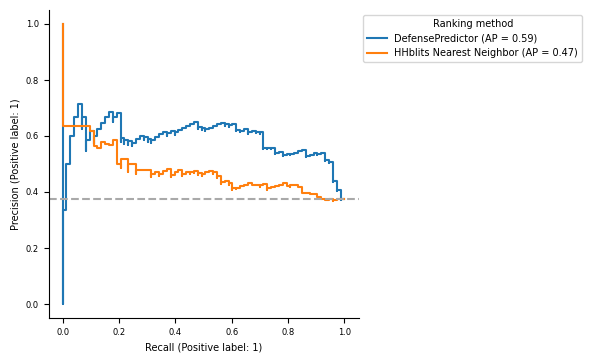

In [47]:
fig, ax = plt.subplots(figsize=(4,4))
metrics.PrecisionRecallDisplay.from_predictions(screened_df['defensive'], screened_df['mean_log_odds'], 
                                                ax=ax, name='DefensePredictor')
metrics.PrecisionRecallDisplay.from_predictions(screened_df['defensive'], screened_df['defense_nn_lo'], 
                                                ax=ax, name='HHblits Nearest Neighbor')
plt.axhline(y=screened_df['defensive'].mean(), linestyle='dashed', color='darkgrey')
sns.despine()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Ranking method')


In [48]:
agg_screened_df = (screened_df.groupby(['working_id', 'defensive'])
                   .agg({'mean_log_odds': 'max', 
                         'defense_nn_lo': 'max'})
                   .reset_index()
                   .sample(frac=1, random_state=7))

In [49]:
agg_screened_df[(agg_screened_df['defense_nn_lo'] < 0) & (agg_screened_df['defensive'])]

working_id  defensive  mean_log_odds  defense_nn_lo
87        SC24       True       6.427335      -2.242481
111       ZAPB       True       3.351004      -0.257412
95        TMO2       True       8.981020      -2.769406
66        PDP4       True      10.504651      -3.547151
3         2971       True       1.371814      -1.373841
41        HIPA       True       6.427269      -2.428837
73        PIN8       True       8.909458      -2.350828
24        D390       True      12.740671      -2.197225
55        MVB1       True       9.664066      -2.806015
75        PN12       True      10.047572      -2.824774
48        INTM       True      -0.062269      -2.338303
39        HEP3       True       9.791017      -3.842009
89        SMEK       True       7.392986      -2.208385
83        REPB       True       7.505866      -1.361479

In [50]:
agg_screened_df[(agg_screened_df['defense_nn_lo'] < 0) & (agg_screened_df['mean_log_odds'] < 0)]

working_id  defensive  mean_log_odds  defense_nn_lo
100       TN31      False      -1.745233      -0.579707
109       YCCE      False      -2.274281      -4.410776
49        LP29      False      -0.280506      -1.496153
18        BRNT      False      -0.266580      -0.493795
98        TMP6      False      -0.533352      -1.992430
29        DINI      False      -0.146617      -1.982994
93        T6SS      False      -0.746602      -1.035599
64        PDO1      False      -0.133128      -2.469836
48        INTM       True      -0.062269      -2.338303
68        PDP6      False      -2.124128      -3.705409

In [52]:
agg_screened_df

working_id  defensive  mean_log_odds  defense_nn_lo
78       RED2       True      10.842512       2.733942
87       SC24       True       6.427335      -2.242481
82       RED9      False       5.976787      -2.338303
96       TMP2      False       7.298315      -1.437067
80       RED7       True       8.059866       1.025281
..        ...        ...            ...            ...
83       REPB       True       7.505866      -1.361479
67       PDP5      False       3.358982       4.820282
25       D668       True       4.944207       0.228995
68       PDP6      False      -2.124128      -3.705409
47       IMPD       True       4.401390       1.840434

[112 rows x 4 columns]

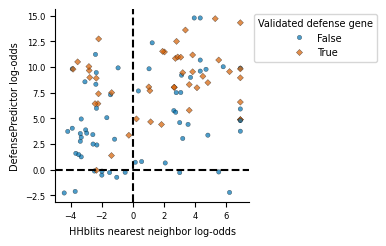

In [57]:
plt.subplots(figsize=(2.5,2.5))
sns.scatterplot(data=agg_screened_df[~agg_screened_df['working_id'].isin(v1_neg_info['working_id'].unique())], 
                x='defense_nn_lo', y='mean_log_odds', hue='defensive',
                palette=bw_color_palette[4:6], style='defensive', markers=["o", "D"],
                edgecolor='Black', alpha=0.7, s=10)
plt.xlabel('HHblits nearest neighbor log-odds')
plt.ylabel('DefensePredictor log-odds')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Validated defense gene')
plt.axvline(x=0, linestyle='dashed', color='black')
plt.axhline(y=0, linestyle='dashed', color='black')
sns.despine()
plt.savefig('../figures/hhblits_dp_screened_no_neg.svg', dpi=300, bbox_inches='tight')

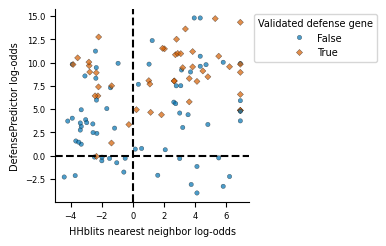

In [58]:
plt.subplots(figsize=(2.5,2.5))
sns.scatterplot(data=agg_screened_df, 
                x='defense_nn_lo', y='mean_log_odds', hue='defensive',
                palette=bw_color_palette[4:6], style='defensive', markers=["o", "D"],
                edgecolor='Black', alpha=0.7, s=10)
plt.xlabel('HHblits nearest neighbor log-odds')
plt.ylabel('DefensePredictor log-odds')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Validated defense gene')
plt.axvline(x=0, linestyle='dashed', color='black')
plt.axhline(y=0, linestyle='dashed', color='black')
sns.despine()
plt.savefig('../figures/hhblits_dp_screened.svg', dpi=300, bbox_inches='tight')

In [61]:
agg_screened_df[agg_screened_df['working_id'].isin(v1_neg_info['working_id'])]

working_id  defensive  mean_log_odds  defense_nn_lo
100       TN31      False      -1.745233      -0.579707
2         2800      False      -3.274338       5.806138
1         2726      False      -3.986439       4.119037
108       VRRN      False      -2.088186       1.599868
0         1064      False      -3.075896       3.748992
110       YQAJ      False      -1.144888       4.119037

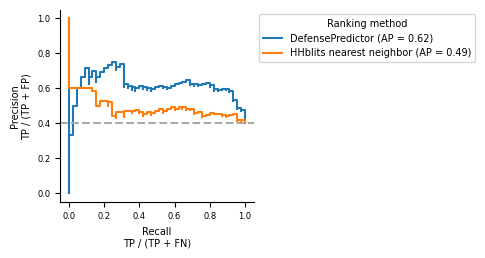

In [59]:
fig, ax = plt.subplots(figsize=(2.5,2.5))
metrics.PrecisionRecallDisplay.from_predictions(agg_screened_df['defensive'], agg_screened_df['mean_log_odds'], 
                                                ax=ax, name='DefensePredictor')
metrics.PrecisionRecallDisplay.from_predictions(agg_screened_df['defensive'], agg_screened_df['defense_nn_lo'], 
                                                ax=ax, name='HHblits nearest neighbor')
plt.axhline(y=agg_screened_df['defensive'].mean(), linestyle='dashed', color='darkgrey')
sns.despine()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Ranking method')
plt.xlabel('Recall\nTP / (TP + FN)')
plt.ylabel('Precision\nTP / (TP + FP)')
plt.savefig('../figures/hhblits_dp_pr.svg', dpi=300, bbox_inches='tight')


In [40]:
end_operons = merged_preds.query('contig_end')['operon']

In [ ]:
skip_negatives = ['WP_087902130.1', 'WP_249546148.1'] # pseduogenes

In [ ]:
possible_negatives = merged_preds[(merged_preds['operon_max_log_odds'] < 0) & 
                                  (~merged_preds['operon'].isin(end_operons)) & 
                                  (~merged_preds['MG1655_homolog']) & 
                                  (merged_preds['defense_nn_lo'] > 0) & 
                                  (~merged_preds['product_accession'].isin(skip_negatives))].copy()

In [ ]:
len(possible_negatives)

1101

In [ ]:
library_size = 25

In [ ]:
sampled_negatives = (possible_negatives
                     .groupby('defense_nn_name')
                     .sample(n=1, random_state=7)
                     .groupby('operon')
                     .sample(n=1, random_state=7)
                     .sample(n=library_size, random_state=7))

Suppose for the sake of argument all the of the negatives are not defensive...

In [ ]:
pretend_sampled_negatives = sampled_negatives[['genomic_accession', 'assembly', 
                                                         'strand', 'product_accession']].copy()
pretend_sampled_negatives['defensive'] = False

In [ ]:
pretend_cat_library_info = pd.concat([cat_library_info, 
                                     pretend_sampled_negatives])

In [ ]:
pretend_screened_df = (merged_preds.merge(pretend_cat_library_info, how='inner', on='product_accession')
               .sample(frac=1, random_state=7)
               .reset_index(drop=True))

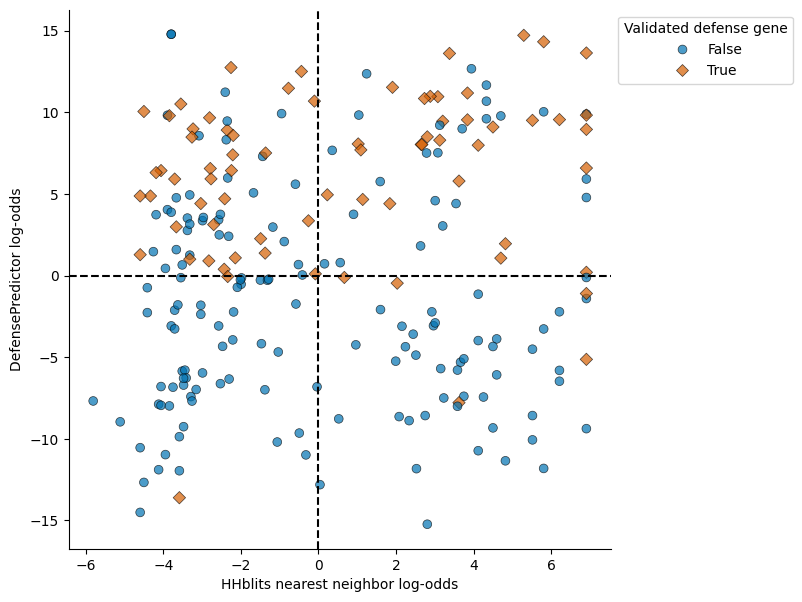

In [ ]:
plt.subplots(figsize=(7,7))
sns.scatterplot(data=pretend_screened_df, x='defense_nn_lo', y='mean_log_odds', hue='defensive',
                palette=bw_color_palette[4:6], style='defensive', markers=["o", "D"],
                edgecolor='Black', alpha=0.7, s=40)
plt.xlabel('HHblits nearest neighbor log-odds')
plt.ylabel('DefensePredictor log-odds')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Validated defense gene')
plt.axvline(x=0, linestyle='dashed', color='black')
plt.axhline(y=0, linestyle='dashed', color='black')
sns.despine()

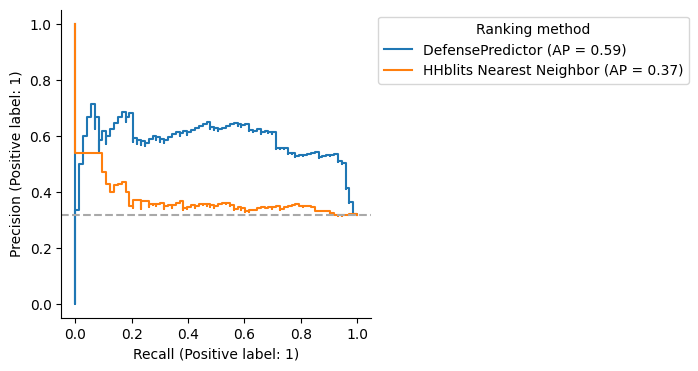

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
metrics.PrecisionRecallDisplay.from_predictions(pretend_screened_df['defensive'], pretend_screened_df['mean_log_odds'], 
                                                ax=ax, name='DefensePredictor')
metrics.PrecisionRecallDisplay.from_predictions(pretend_screened_df['defensive'], pretend_screened_df['defense_nn_lo'], 
                                                ax=ax, name='HHblits Nearest Neighbor')
plt.axhline(y=pretend_screened_df['defensive'].mean(), linestyle='dashed', color='darkgrey')
sns.despine()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Ranking method')


In [65]:
n_neighbors = 10

In [66]:
sorted_predictions = (pred_df.sort_values(['genomic_accession', 'start'])
                      .reset_index(drop=True))

In [67]:
norm = TwoSlopeNorm(vmin=pred_df['mean_log_odds'].min(), 
                    vcenter=0, 
                    vmax=pred_df['mean_log_odds'].max())
cmap = plt.get_cmap('RdBu_r')

/state/partition1/slurm_tmp/1183421.0.0/ipykernel_1397597/3096141508.py:46: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Log-odds of defense', location='bottom', shrink=0.5)


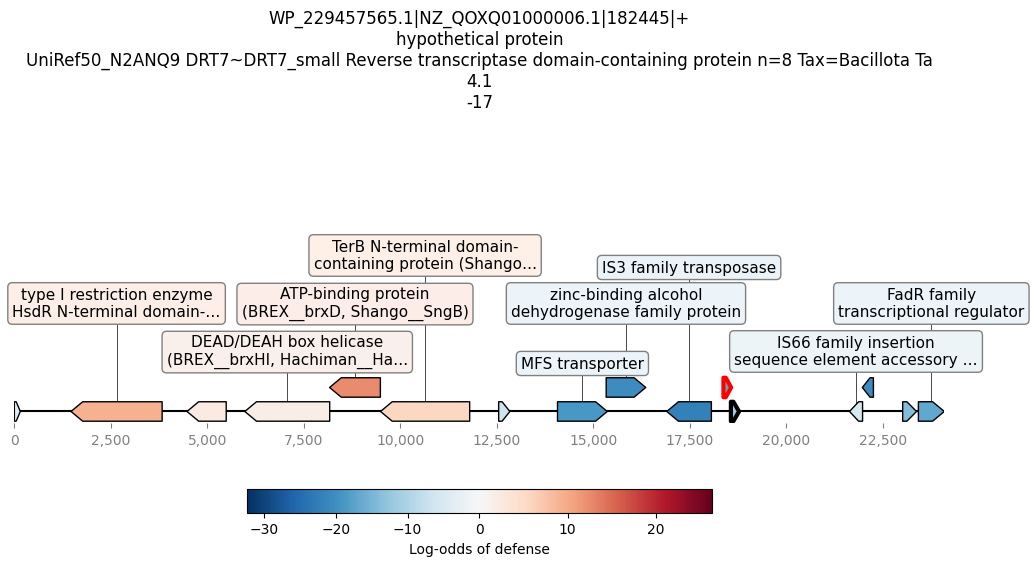

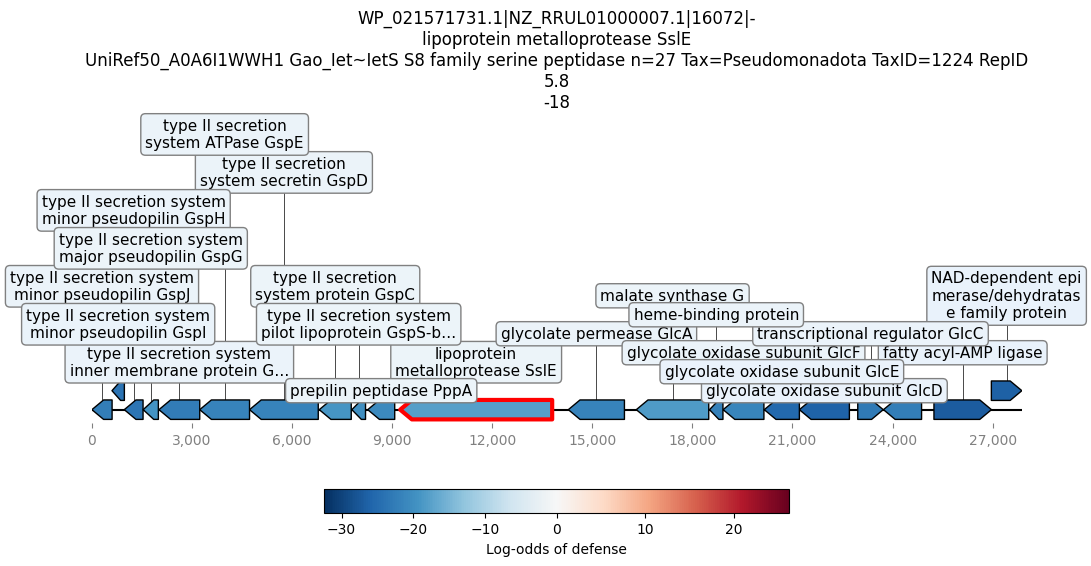

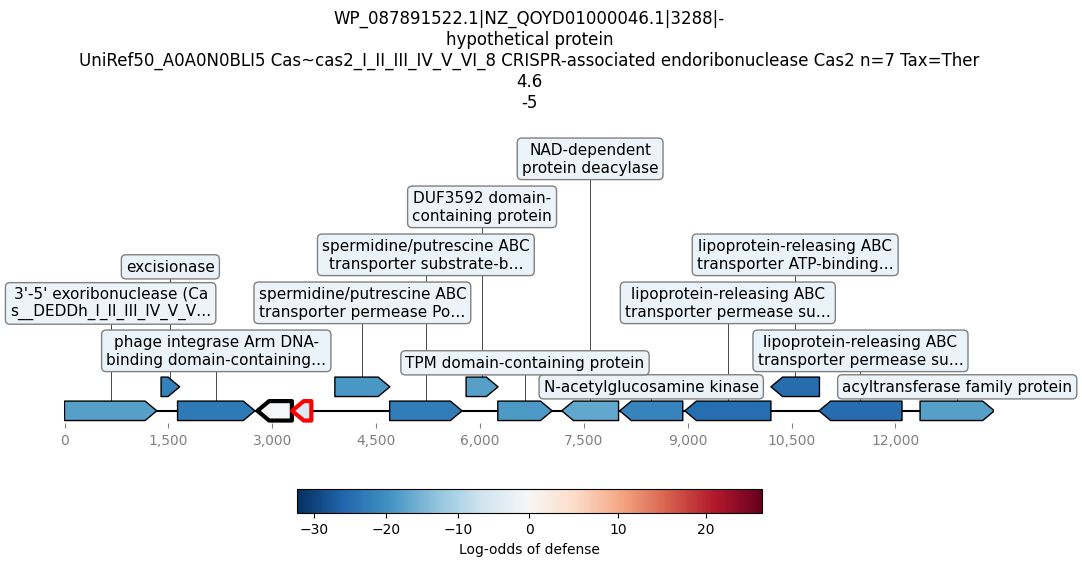

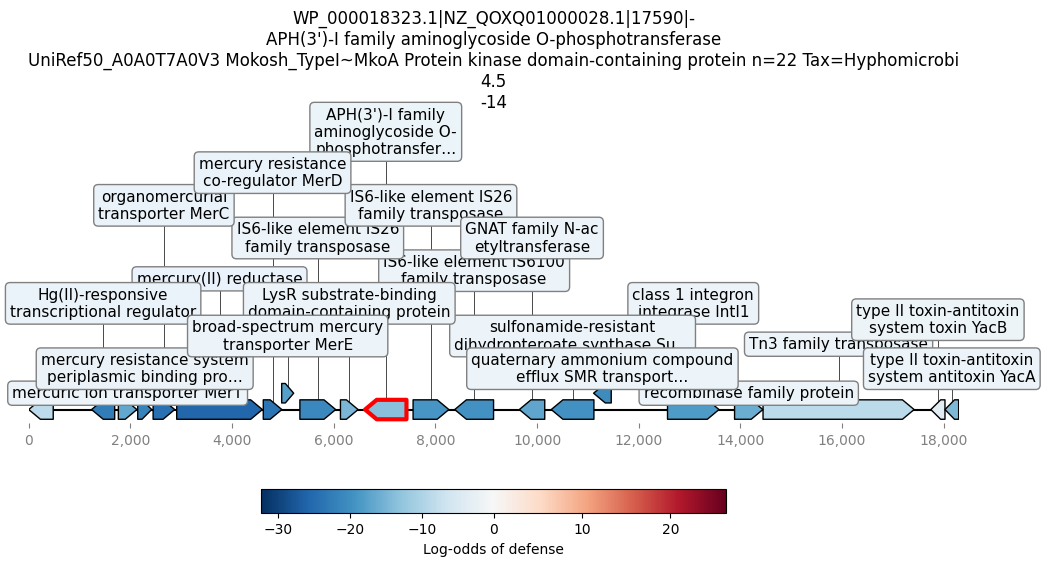

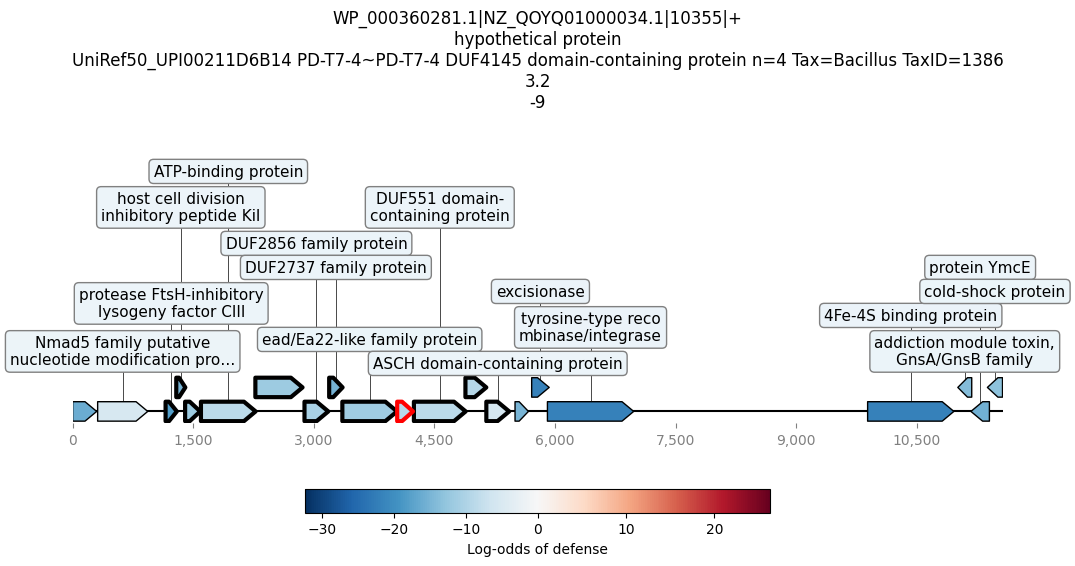

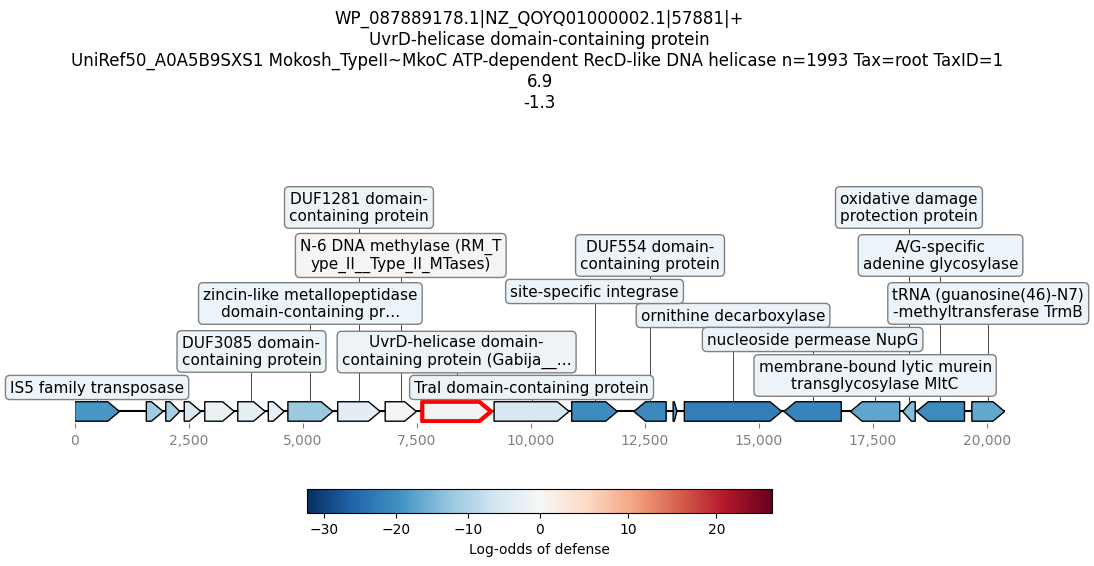

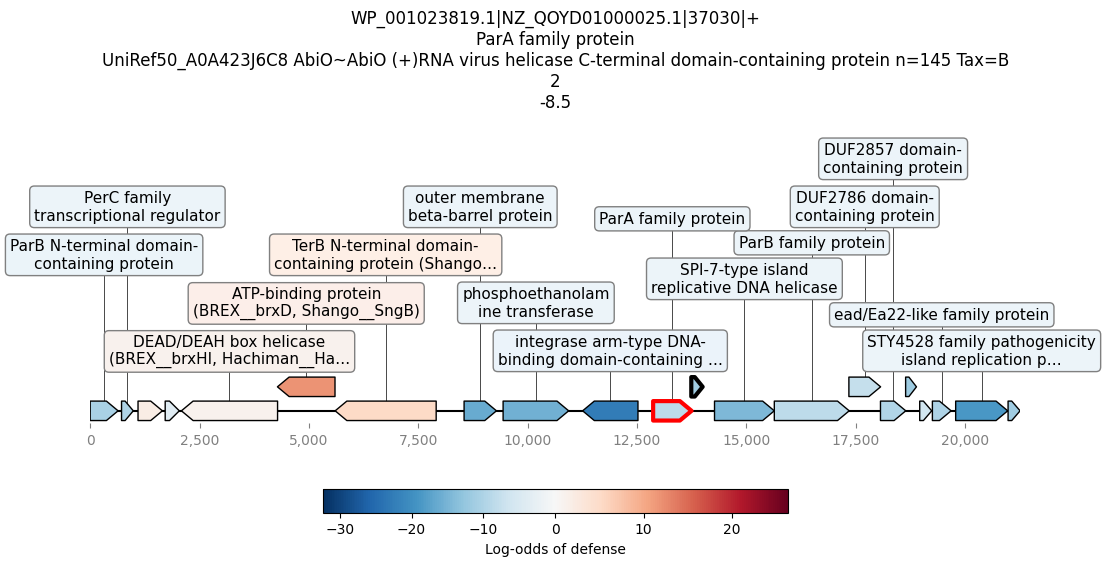

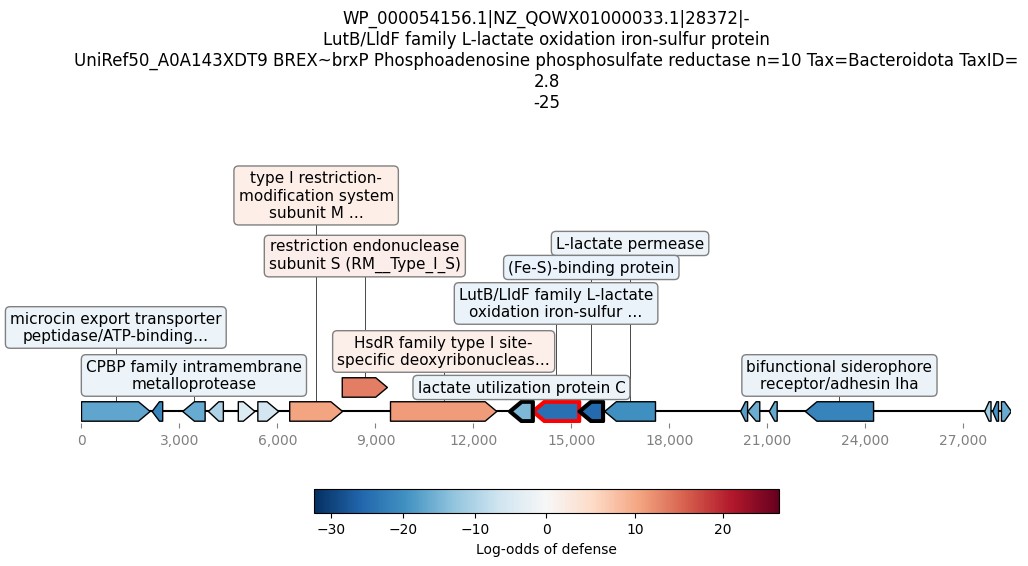

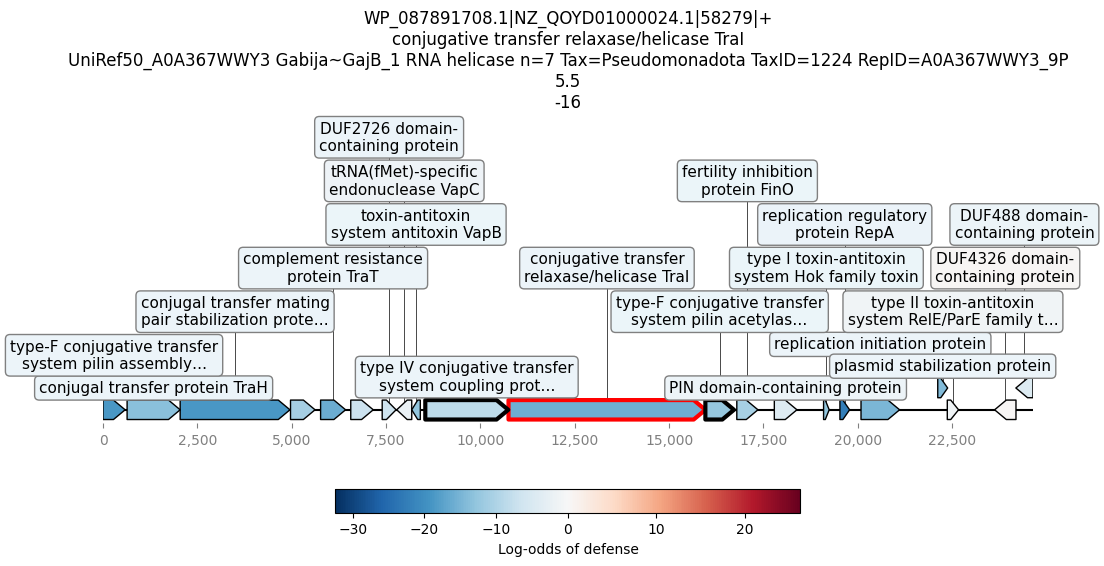

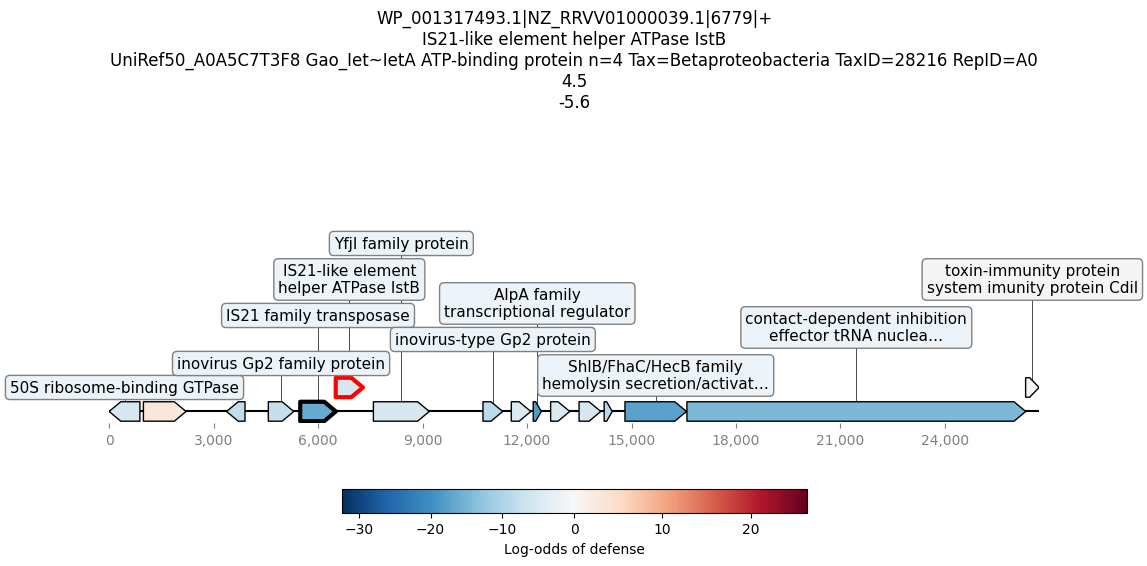

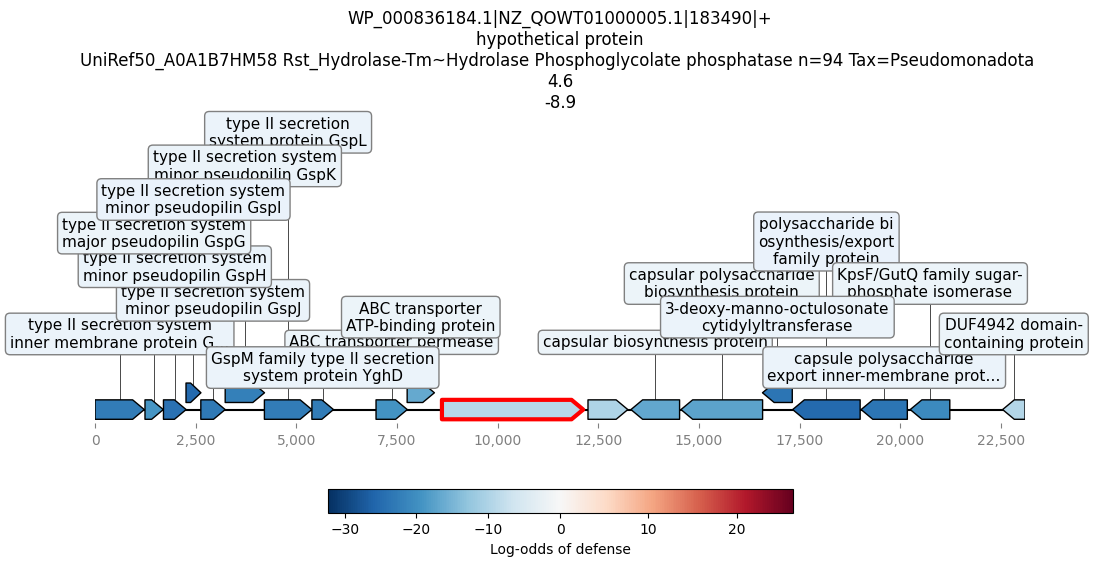

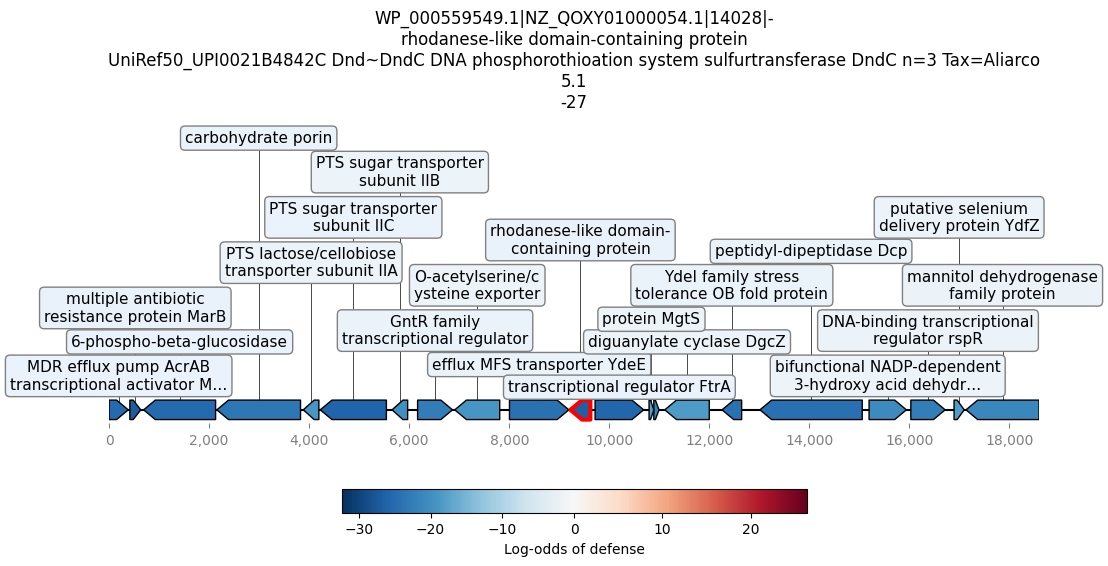

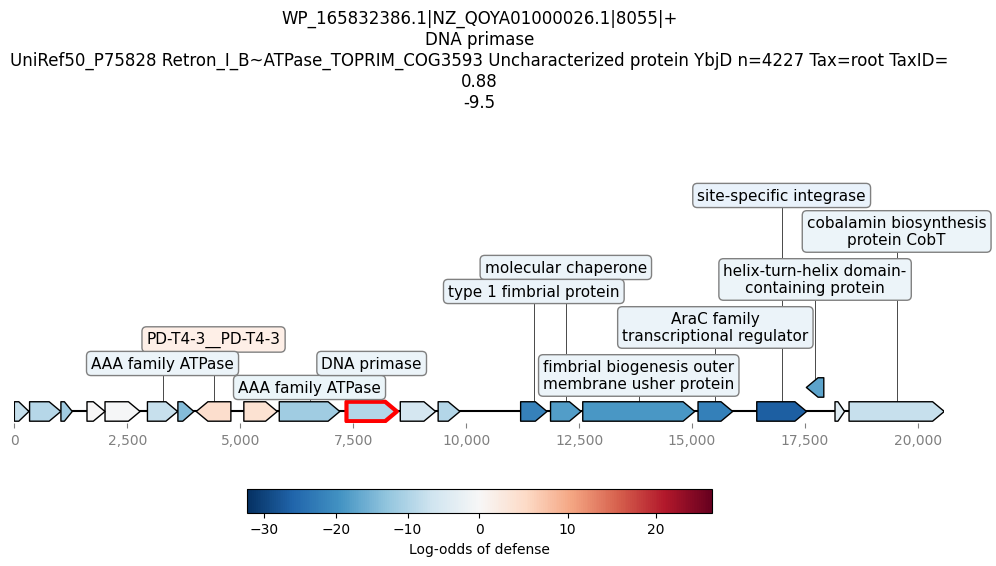

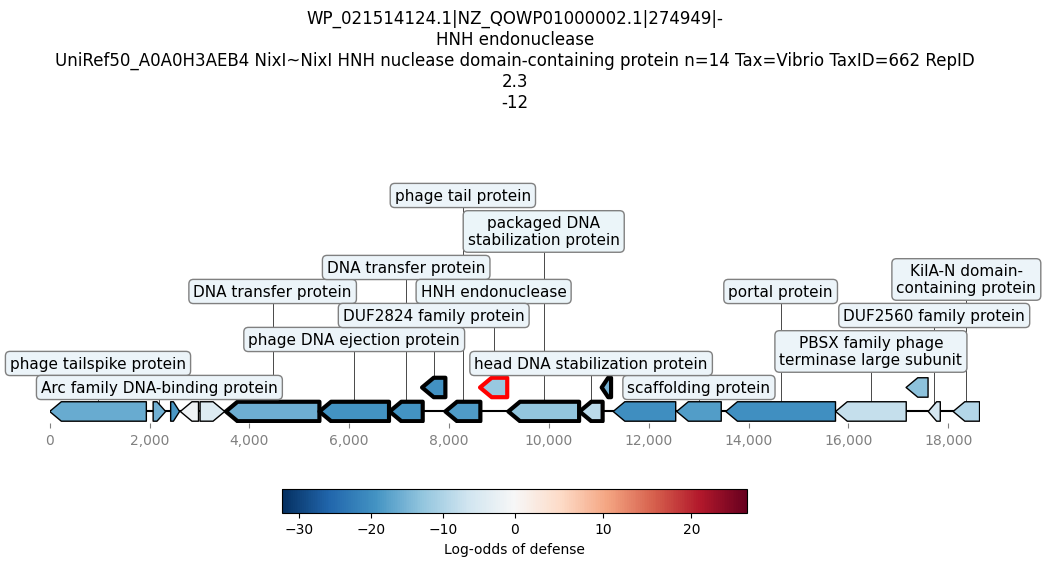

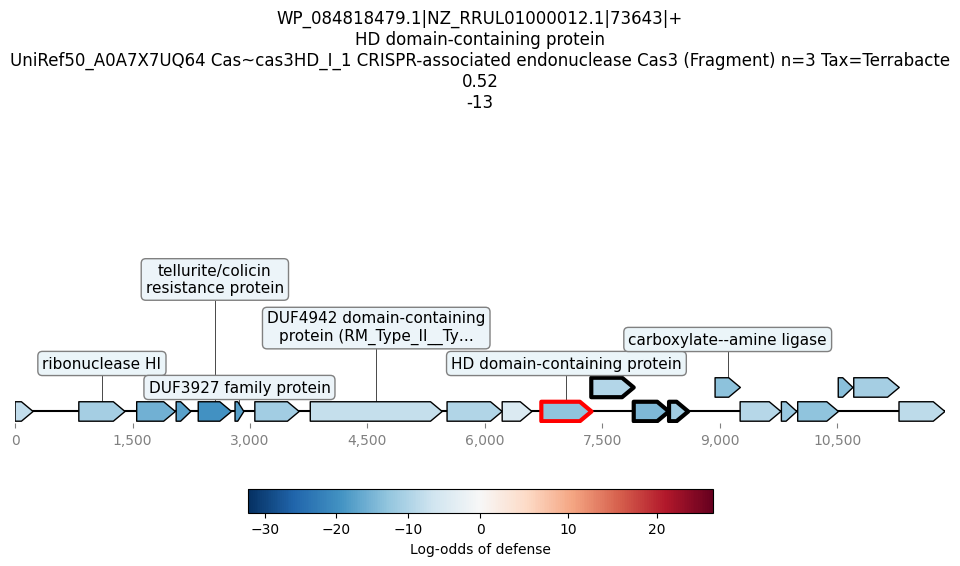

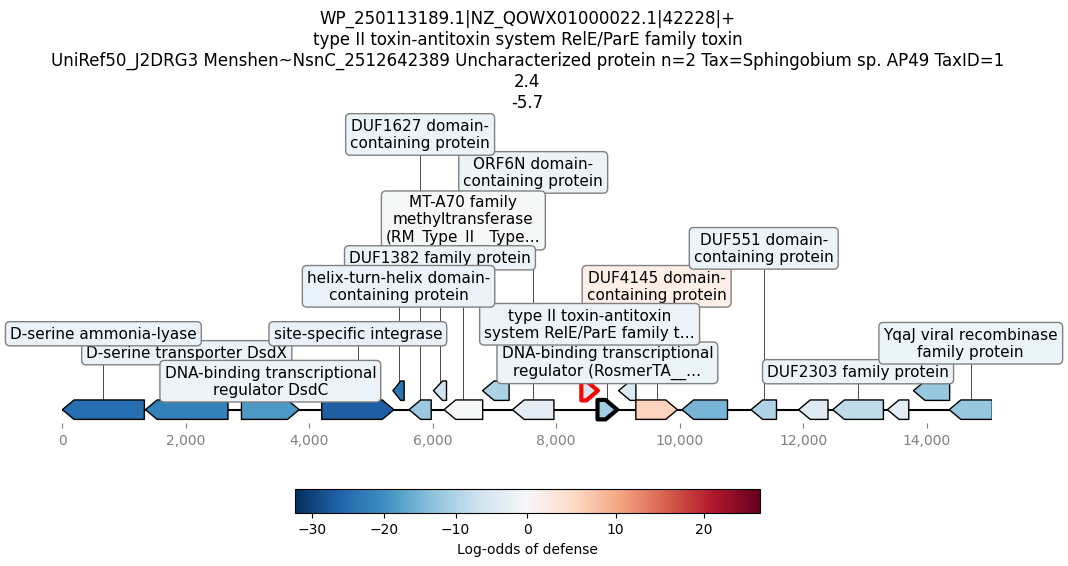

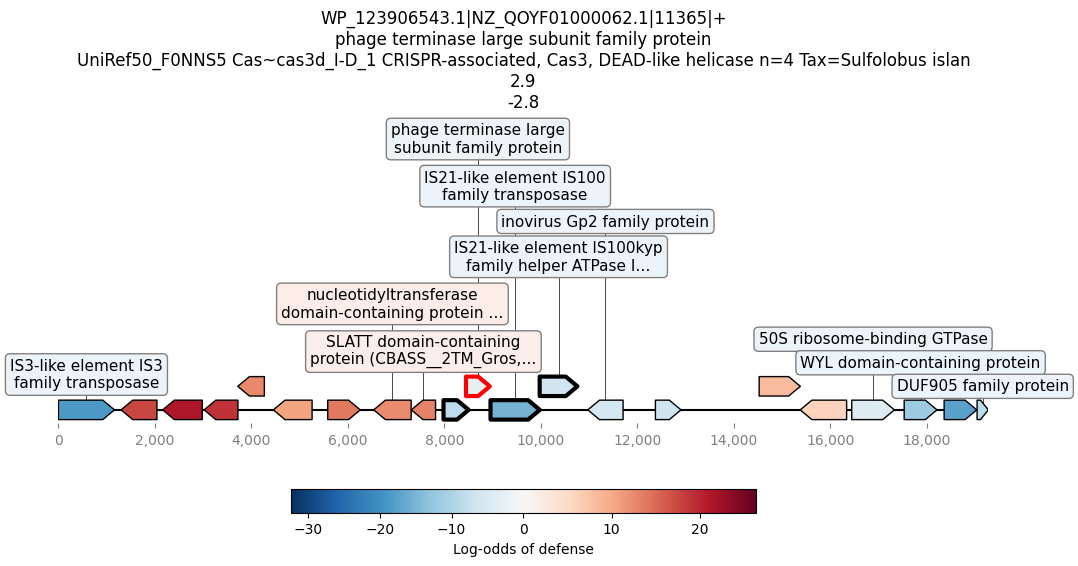

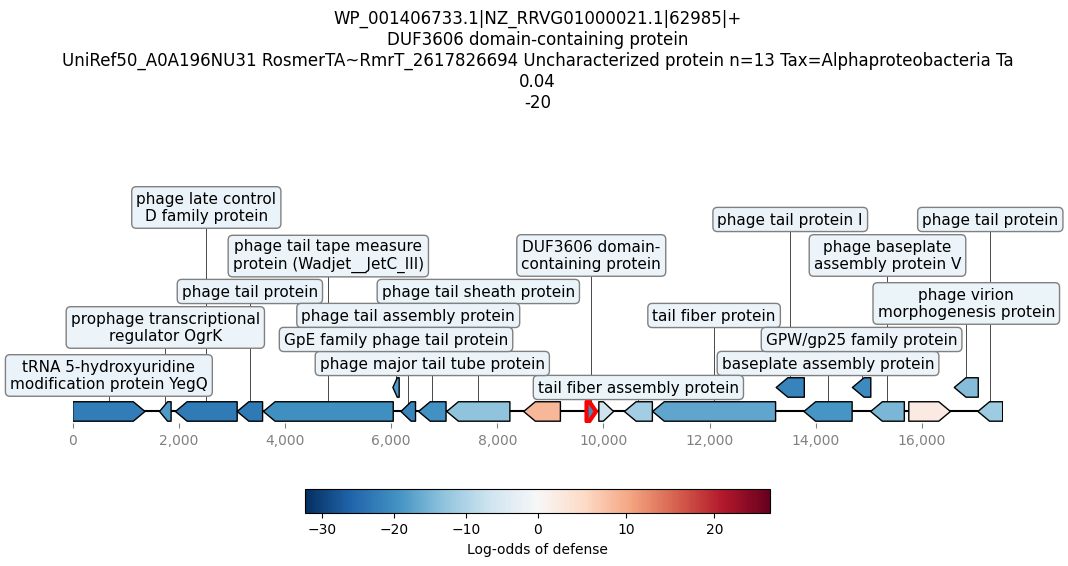

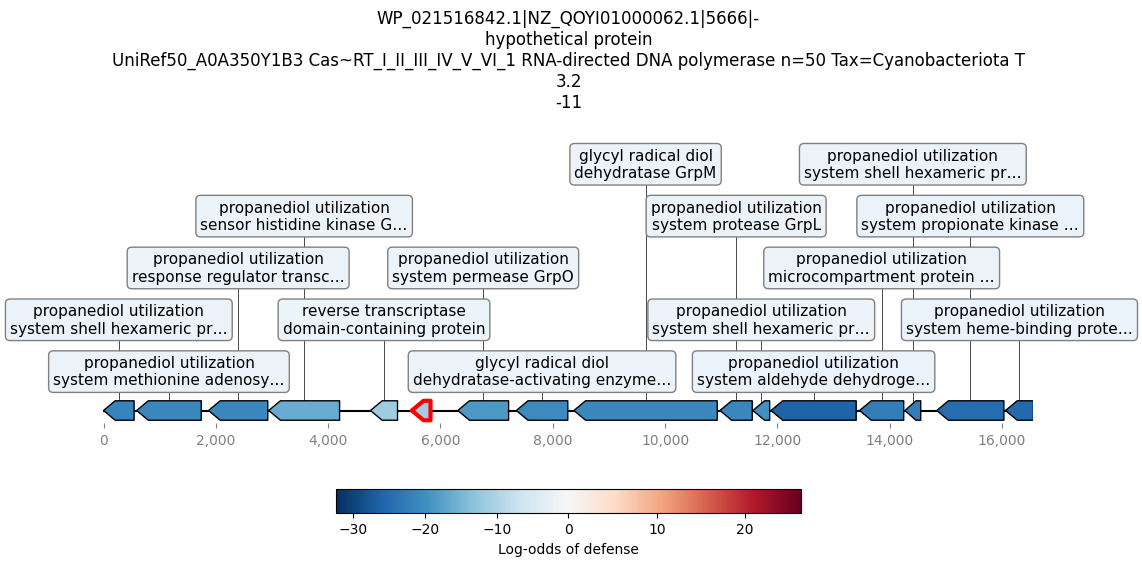

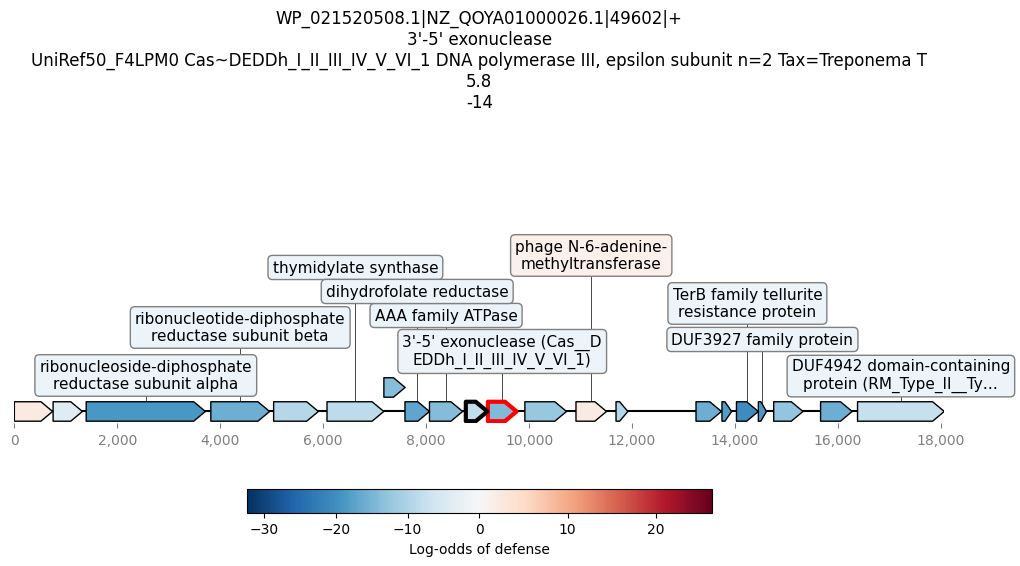

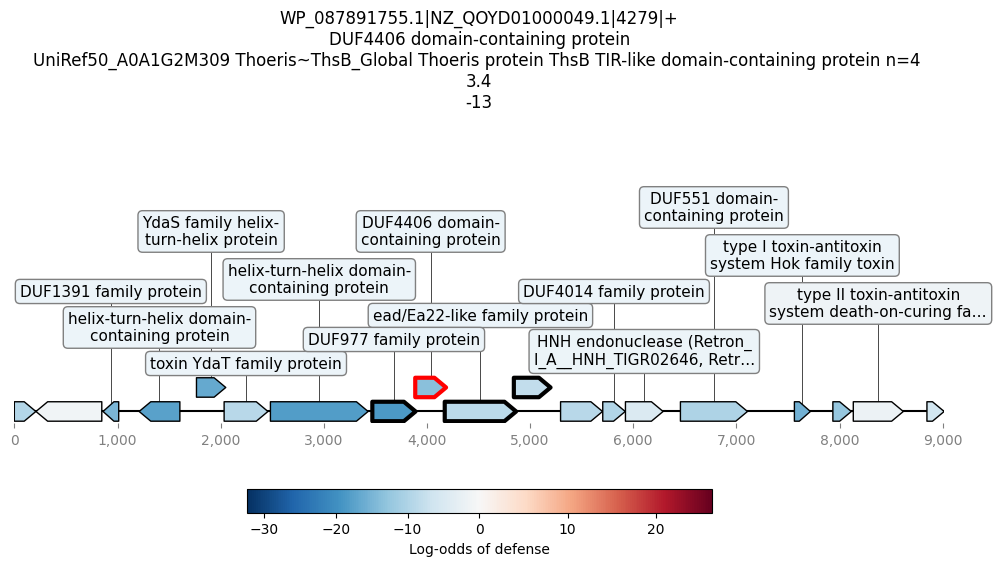

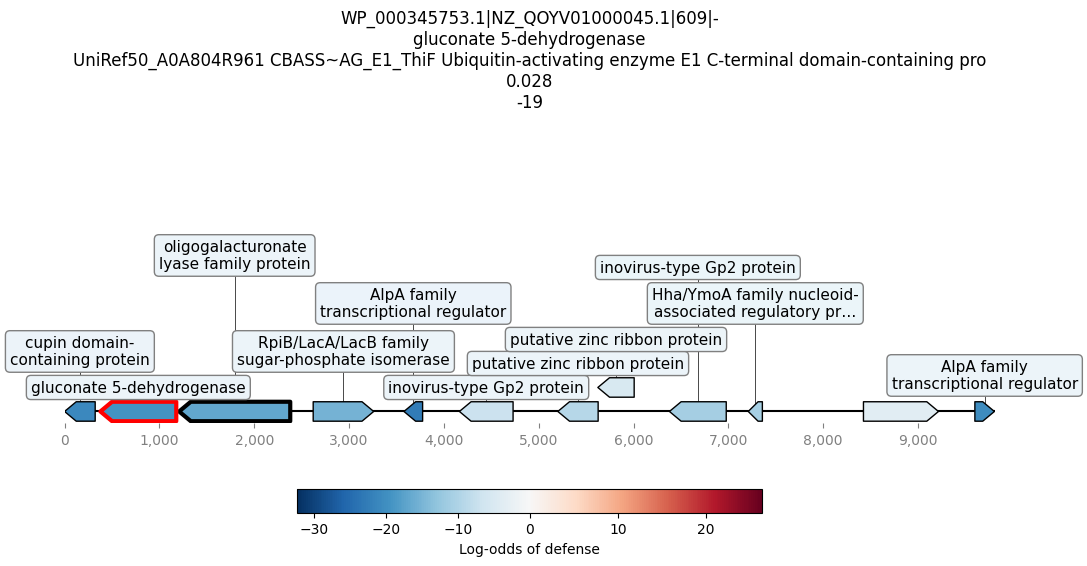

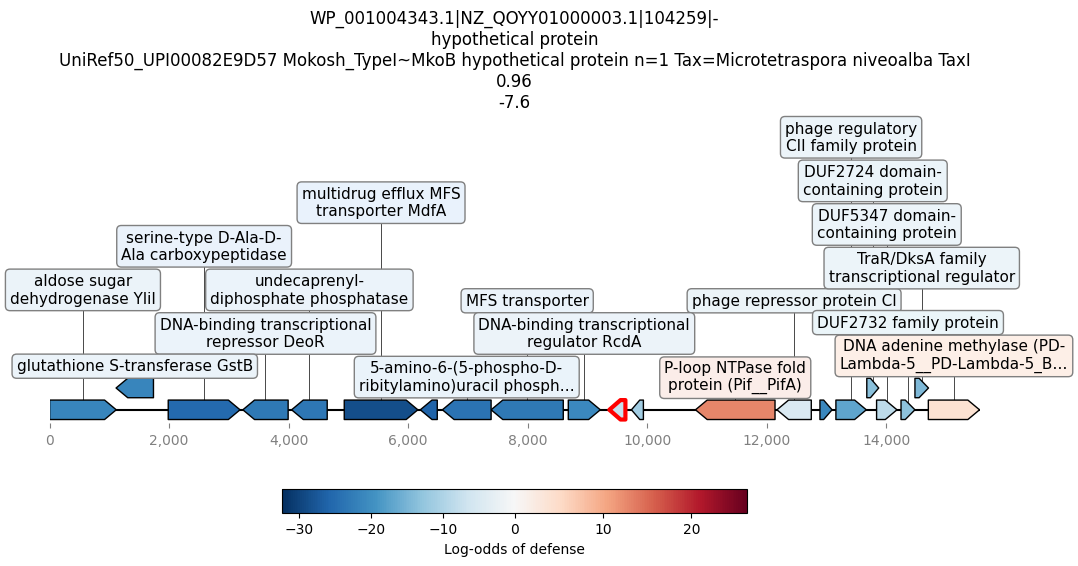

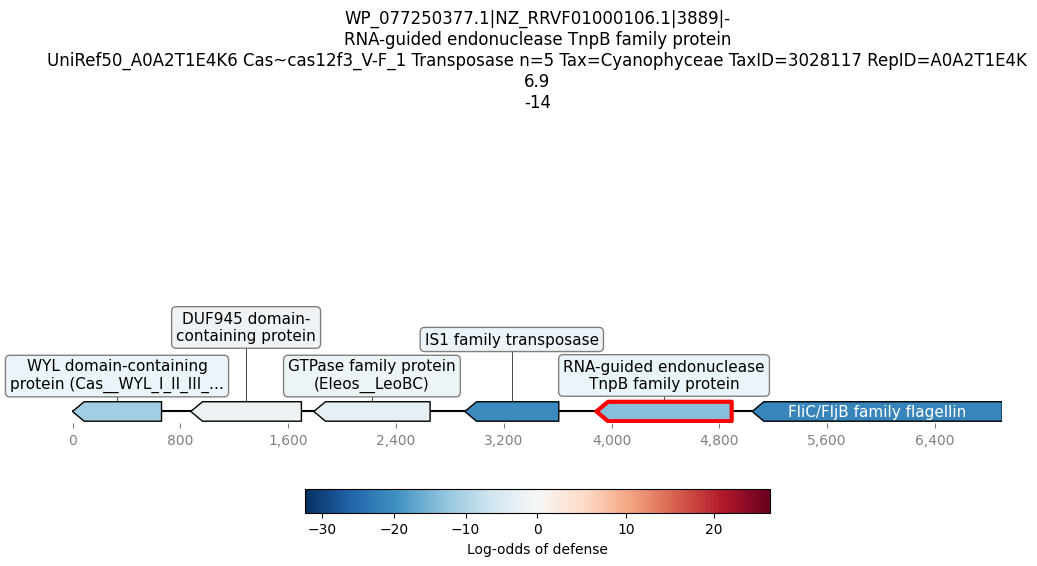

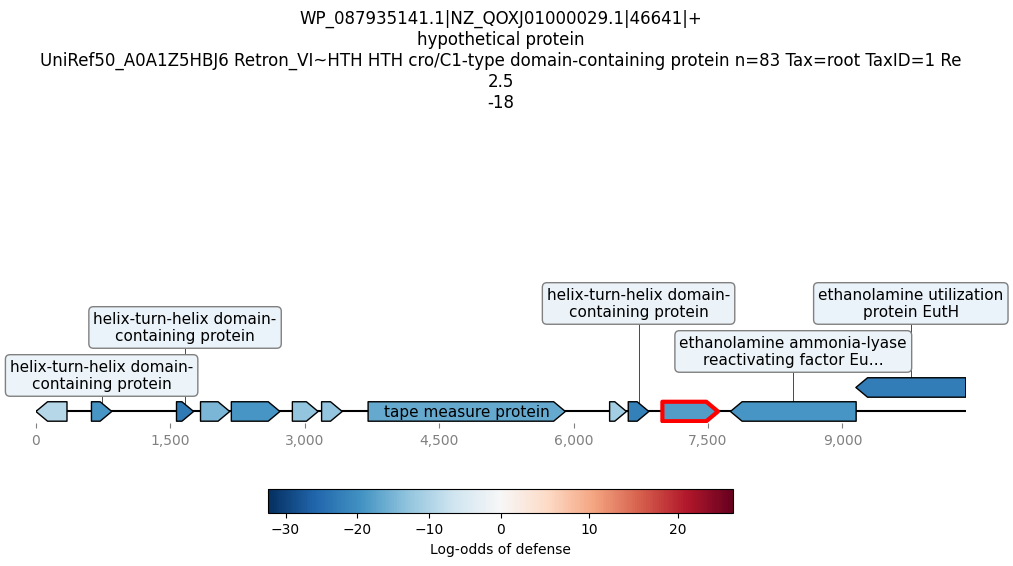

In [68]:
for _, row in sampled_negatives.iterrows():
    title = '\n'.join([row['protein_context_id'], row['name'], row['defense_nn_name'][:100], f"{row['defense_nn_lo']:.2g}", 
                       f"{row['mean_log_odds']:.2g}"])
    center_row = sorted_predictions[sorted_predictions['protein_context_id'] == row['protein_context_id']].squeeze()
    neighbor_df = sorted_predictions.iloc[(center_row.name - n_neighbors):(center_row.name + n_neighbors + 1), :]
    neighbor_df = neighbor_df[neighbor_df['genomic_accession'] == center_row['genomic_accession']]
    min_start = neighbor_df['start'].min()
    max_end = neighbor_df['end'].max()
    features = list()
    for _, gene in neighbor_df.iterrows():
        start = gene['start'] - min_start
        end = gene['end'] - min_start
        if gene['strand'] == '+':
            strand = 1
        else:
            strand = -1
        if (gene['protein_context_id'] == center_row['protein_context_id']):
            linecolor = 'red'
        else:
            linecolor = 'black'
        if gene['defense_system_protein']:
            label = gene['defense_homolog_names']
        elif not pd.isna(gene['defense_homolog_names']):
            if gene['name'] != 'hypothetical protein':
                label = f"{gene['name']} ({gene['defense_homolog_names']})"
            else:
                label = gene['defense_homolog_names']    
        elif gene['name'] == 'hypothetical protein':
            label = None
        else:
            label = gene['name']
        if gene['operon'] == center_row['operon']:
            linewidth = 3
        else:
            linewidth = 1
        color = cmap(norm(gene['mean_log_odds']))
        feature = GraphicFeature(start=start, end=end, strand=strand, linecolor=linecolor, 
                                 label=label, color=color, linewidth=linewidth)
        features.append(feature)
    record = GraphicRecord(sequence_length=(max_end - min_start + 1), features=features)
    _, ax = plt.subplots(figsize=(12, 5))
    record.plot(ax=ax)
    plt.subplots_adjust(bottom=0)
    plt.title(title)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, label='Log-odds of defense', location='bottom', shrink=0.5)
    plt.show()

In [ ]:
sampled_negatives.to_csv('../data3/interim/hhpred_ecor_sampled_negatives.csv', index=False)

In [ ]:
sampled_negatives

protein_context_id  mean_log_odds  sd_log_odds   
2744  WP_021514124.1|NZ_QOWP01000002.1|274949|-      -8.890782     3.602093  \
3358  WP_000836184.1|NZ_QOWT01000005.1|183490|+      -6.085667     1.435876   
2266   WP_250113189.1|NZ_QOWX01000022.1|42228|+      -3.593619     2.343325   
2267   WP_016232243.1|NZ_QOWX01000022.1|42490|+      -7.443916     2.023873   
5384   WP_000431499.1|NZ_QOWX01000033.1|27670|-      -9.261884     1.275213   
5385   WP_000054156.1|NZ_QOWX01000033.1|28372|-     -15.235944     1.196323   
9898   WP_000544018.1|NZ_QOWX01000033.1|30567|-     -14.511072     2.185488   
7454   WP_087935141.1|NZ_QOXJ01000029.1|46641|+     -11.832594     1.467085   
4155  WP_229457565.1|NZ_QOXQ01000006.1|182445|+     -10.733045     1.168326   
4154  WP_023148293.1|NZ_QOXQ01000006.1|182638|+      -7.397311     1.192109   
5431   WP_000018323.1|NZ_QOXQ01000028.1|17590|-      -9.333637     0.974017   
3217   WP_087891707.1|NZ_QOYD01000024.1|56074|+      -5.811476     1.631221   
3219   WP_087891708.1|NZ_QOYD01000024.1|58279|+     -10.068299     1.202595   
3218   WP_087891709.1|NZ_QOYD01000024.1|63495|+      -8.962482     1.759442   
2970   WP_001023819.1|NZ_QOYD01000025.1|37030|+      -5.247761     1.803278   
2971   WP_000240583.1|NZ_QOYD01000025.1|37902|+      -6.983615     2.239635   
2407   WP_001004373.1|NZ_QOYD01000025.1|43124|+      -3.943108     2.099880   
2408   WP_001084423.1|NZ_QOYD01000025.1|43414|+      -5.967048     2.696745   
4345   WP_000903464.1|NZ_QOYD01000025.1|45144|+      -7.685279     1.470939   
922     WP_064236780.1|NZ_QOYD01000046.1|2788|-       2.078057     2.193883   
923     WP_087891522.1|NZ_QOYD01000046.1|3288|-      -3.883111     0.944050   
1799   WP_000999908.1|NZ_QOYF01000062.1|10899|+      -4.877179     2.058924   
1798   WP_123906543.1|NZ_QOYF01000062.1|11365|+      -2.224737     1.019653   
3591    WP_001362989.1|NZ_QOYI01000062.1|4929|-      -6.476317     1.964087   
4216    WP_021516842.1|NZ_QOYI01000062.1|5666|-      -7.500994     1.307637   
1553   WP_087889178.1|NZ_QOYQ01000002.1|57881|+      -1.412257     1.862990   
2884   WP_000360281.1|NZ_QOYQ01000034.1|10355|+      -5.703270     1.960143   
2516  WP_001004343.1|NZ_QOYY01000003.1|104259|-      -4.246660     2.019591   
7440   WP_021571731.1|NZ_RRUL01000007.1|16072|-     -11.817700     1.849287   
3807   WP_084818479.1|NZ_RRUL01000012.1|73643|+      -8.779981     1.307641   
3806   WP_060460706.1|NZ_RRUL01000012.1|75274|+      -6.841340     0.927235   
5460    WP_077250377.1|NZ_RRVF01000106.1|3889|-      -9.381336     1.010103   
8361   WP_001406733.1|NZ_RRVG01000021.1|62985|+     -12.813617     1.430773   
2618   WP_000002748.1|NZ_RRVG01000021.1|63217|+      -4.513359     1.109734   
2555    WP_001317493.1|NZ_RRVV01000039.1|6779|+      -4.349074     1.060301   

      min_log_odds  max_log_odds # feature         class         assembly   
2744    -15.669055     -5.549958       CDS  with_protein  GCF_003334355.1  \
3358     -8.654180     -4.201804       CDS  with_protein  GCF_003334765.1   
2266     -7.147543      0.116001       CDS  with_protein  GCF_003334775.1   
2267     -9.868793     -4.948252       CDS  with_protein  GCF_003334775.1   
5384    -10.836771     -7.664651       CDS  with_protein  GCF_003334775.1   
5385    -17.550694    -14.211942       CDS  with_protein  GCF_003334775.1   
9898    -18.196528    -11.708678       CDS  with_protein  GCF_003334775.1   
7454    -13.583894     -9.727491       CDS  with_protein  GCF_003334085.1   
4155    -12.234439     -9.129321       CDS  with_protein  GCF_003333945.1   
4154     -9.085823     -5.585620       CDS  with_protein  GCF_003333945.1   
5431    -10.277883     -7.871135       CDS  with_protein  GCF_003333945.1   
3217     -7.576934     -3.163236       CDS  with_protein  GCF_003333765.1   
3219    -11.255538     -7.981059       CDS  with_protein  GCF_003333765.1   
3218    -11.989317     -6.521988       CDS  with_protein  GCF_003333765.1   
2970     -8.593429     -3.291